In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import numpy as np
import os
import glob
import pandas as pd

!pip install pygame

import pygame.midi 
import time
from scipy.io import wavfile

#Forecasting a Time Series

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
n_count = 10000

In [ ]:
series = generate_time_series(n_count, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

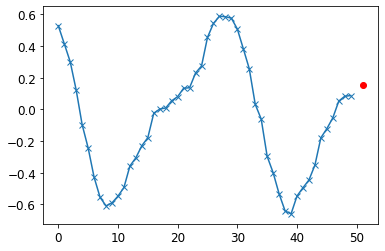

In [ ]:
i = 6
plt.plot(np.arange(n_steps), X_train[i], marker='x')
plt.plot(n_steps+1, y_train[i], color='r', marker='o')

###Baseline Metrics

In [ ]:
#naive forecasting
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_pred, y_valid))

0.020211367

результирующая модель должна превзойти эту метрику.


Другой подход для получения метрики - использовать полносвязанную нейросеть

In [ ]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[50, 1]),
  keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=0)
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0036


0.0036232201382517815

###Implementing a Simple RNN

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1]),
])
model.compile(optimizer="adam", loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=0)
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0139


0.013911684043705463

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(50, input_shape=[None, 1]),
])
model.compile(optimizer="adam", loss='mse')
model.fit(X_train, y_train, epochs=2)
model.evaluate(X_valid, y_valid)

Epoch 1/2
219/219 [==============================] - 6s 27ms/step - loss: 0.0711
Epoch 2/2
63/63 [==============================] - 0s 4ms/step - loss: 0.0274


0.027411751449108124

###Deep RNNs 


In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.SimpleRNN(1, )
])
model.compile(optimizer="adam", loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=0)
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0029


0.0029105590656399727

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=0)
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0026


0.00258334307000041

###Forecasting Several Time Steps Ahead

In [ ]:
data_ = np.r_[X_train[0], y_train[0].reshape(-1, 1)]
temp_x, temp_y = data_[:40, ], data_[40:, ]

In [ ]:
temp = np.array([temp_x])
for i in range(11):
  y_pred = model.predict(temp)
  temp = np.concatenate([temp, y_pred[np.newaxis, :, :]], axis=1)
y_pred = temp[:, -11:, :]

ниже красным пунктиром показано как бы имеющая нейросеть предсказала временную последовательность из 11 значений.

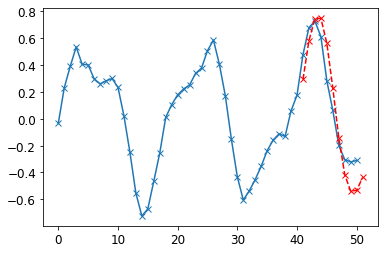

In [ ]:
plt.plot(np.arange(51), data_, marker='x')
plt.plot(np.arange(y_pred.shape[1])+41, y_pred[0], '--', marker='x', color='r')

**Другой подход это предсказывать сразу вектор значений.**

In [ ]:
series = generate_time_series(n_count, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:]

In [ ]:
y_train = y_train.reshape(y_train.shape[:-1])
y_valid = y_valid.reshape(y_valid.shape[:-1])
y_test  = y_test.reshape(y_test.shape[:-1])

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, 
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(10)
])
model.compile(optimizer="adam", loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=0)
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0085


0.008533000014722347

In [ ]:
y_pred = model.predict(X_valid[0][np.newaxis, :, :])

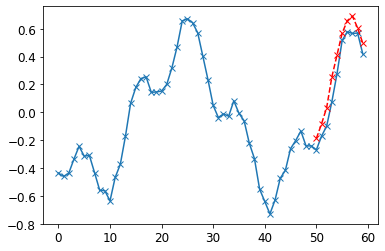

In [ ]:
data_ = np.r_[X_valid[0][:, 0], y_valid[0]]
plt.plot(np.arange(60), data_, marker='x')
plt.plot(np.arange(10)+50, y_pred[0], '--', marker='x', color='r')

**улучшим результат следующей техникой**

In [ ]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, verbose=0)

In [ ]:
model.evaluate(X_train, Y_train)

219/219 [==============================] - 2s 7ms/step - loss: 0.0181 - last_time_step_mse: 0.0063


[0.01805393025279045, 0.00628094095736742]

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0179 - last_time_step_mse: 0.0064


[0.01790889911353588, 0.006404873449355364]

In [ ]:
y_pred = model.predict(X_valid[0][np.newaxis, :, :])
y_pred = y_pred[:, -1]

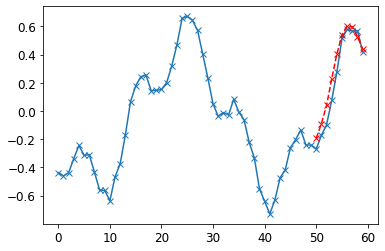

In [ ]:
data_ = np.r_[X_valid[0][:, 0], y_valid[0]]
plt.plot(np.arange(60), data_, marker='x')
plt.plot(np.arange(10)+50, y_pred[0], '--', marker='x', color='r')

#Handling Long Sequences

### Fighting the Unstable Gradients Problem

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential([
  keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
  keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, verbose=0)

In [ ]:
model.evaluate(X_valid, Y_valid)

219/219 [==============================] - 3s 14ms/step - loss: 0.0185 - last_time_step_mse: 0.0065


[0.018452312797307968, 0.006485589314252138]

### Tackling the Short-Term Memory Problem

#### LSTM

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential([
  keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.LSTM(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, verbose=0)
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0131 - last_time_step_mse: 0.0026


[0.013056538999080658, 0.0025856955908238888]

#### Peephole connections

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential([
  keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(20), 
                   return_sequences=True, input_shape=[None, 1]),
  keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(20), 
                   return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, verbose=0)
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 2s 35ms/step - loss: 0.0130 - last_time_step_mse: 0.0027


[0.013047215528786182, 0.0027251136489212513]

#### GRU cells (Gated Recurrent Unit) 


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential([
  keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, verbose=0)
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0142 - last_time_step_mse: 0.0034


[0.01418237667530775, 0.003404415911063552]

#### Using 1D CNN to process sequences

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                      input_shape=[None, 1]),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train[:, 3::2], epochs=20, verbose=0)
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 [==============================] - 0s 3ms/step - loss: 0.0107 - last_time_step_mse: 0.0033


[0.010687978938221931, 0.0033367283176630735]

#### WaveNet

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1,2,4,8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                activation="relu", dilation_rate=pow(2, rate)))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, verbose=0)
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0220 - last_time_step_mse: 0.0100


[0.02202020399272442, 0.009950240142643452]

#Tasks

### task1

*Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, and a vector-to-sequence RNN?*

• For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation),
identifying the chords of a song

• For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of collaborative filtering for a recommender system)

• For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a
set of parameters, locating pedestrians in a picture (e.g., a video frame from a
self-driving car’s camera)

### task2

*How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?*

- inputs: [batch_size, time_steps_size, data_features]

- outputs: [batch_size, time_steps_size, n_neurons], где n_neurons - кол-во нейронов на последнем RNN слое при параметре return_sequences=True, в противном случае - 1 вывод.

### task3

*If you want to build a deep sequence-to-sequence RNN, which RNN layers should have return_sequences=True? What about a sequence-to-vector RNN?*


- Каждый слой дожлен иметь return_sequences=True

- Последний RNN слой return_sequences=false, а остальные как в 1


#### task4

*Suppose you have a daily univariate time series, and you want to forecast the next seven days. Which RNN architecture should you use?*

If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with return_sequences=True except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set return_sequences=True for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step t, the target should be a vector containing the values at time steps t + 1 to t + 7). 



#### task5

*What are the main difficulties when training RNNs? How can you handle them?*

Две проблемы:

- проблема градиентов;
- проблема изучения всех возможных  парттернов в данных на различной дистации: как коротко-срочные, так и долгосрочные.

Для преодоления проблемы градиентов используется LN, функция гиперболического тангенса в качестве фукнции активации, gradient clipping, маленький learning rate, dropout.

Для решения проблемы изучения паттернов используется архитектуры: LSTM, GRU или WaveNet.


#### task6

*Can you sketch the LSTM cell’s architecture?*

Основной принцип заключает в том, ячейка LSTM запоминает long-term и short-term состояния. На каждом временном шаге short-term состояние и input проходят через обычную RNN. Есть несколько ворот:

foget gate - определяют что исключить из long-term state;
input gate - определяет какой вывод из RNN ячейки должен быть добавлен к long-term state;
output gate - опеределяеет какая часть long-term должна идти на вывод после прохождения tanh активационной фукнции.

Новый short-temp тот же, что и вывод.



#### task7

*Why would you want to use 1D convolutional layers in an RNN?*

RNN сети медленно обучаются, т.к. не могу вычислять в параллели поскольку для шага t необходимо получить данные из шага (t-1). Еще один минус - RNN сети склонны забывать данные в длинных последовательностях (проблема изучения long-term паттернов). 

Conv1D могут вычислять парралелльно и, кроме того, путем указания kernel_size можно управлять размерном паттерна для обучения.


#### task8

*Which neural network architecture could you use to classify videos?*

To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

#### task9

*Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.*

##### Загрузка данных в dataset

In [ ]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="/content/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 13s 0us/step


In [ ]:
quickdraw_dir = os.path.dirname(filepath) + '/'

eval_files  = glob.glob(quickdraw_dir + 'eval.tfrecord-*')
train_files = glob.glob(quickdraw_dir + 'training.tfrecord-*')

In [ ]:
eval_files, train_files

(['/content/quickdraw/eval.tfrecord-00000-of-00010',
  '/content/quickdraw/eval.tfrecord-00007-of-00010',
  '/content/quickdraw/eval.tfrecord-00004-of-00010',
  '/content/quickdraw/eval.tfrecord-00005-of-00010',
  '/content/quickdraw/eval.tfrecord-00006-of-00010',
  '/content/quickdraw/eval.tfrecord-00009-of-00010',
  '/content/quickdraw/eval.tfrecord-00002-of-00010',
  '/content/quickdraw/eval.tfrecord-00008-of-00010',
  '/content/quickdraw/eval.tfrecord-00001-of-00010',
  '/content/quickdraw/eval.tfrecord-00003-of-00010'],
 ['/content/quickdraw/training.tfrecord-00005-of-00010',
  '/content/quickdraw/training.tfrecord-00000-of-00010',
  '/content/quickdraw/training.tfrecord-00001-of-00010',
  '/content/quickdraw/training.tfrecord-00006-of-00010',
  '/content/quickdraw/training.tfrecord-00004-of-00010',
  '/content/quickdraw/training.tfrecord-00007-of-00010',
  '/content/quickdraw/training.tfrecord-00009-of-00010',
  '/content/quickdraw/training.tfrecord-00008-of-00010',
  '/content/q

In [ ]:
with open(quickdraw_dir + 'training.tfrecord.classes', 'r') as train_file:
  train_classes = train_file.readlines()
with open(quickdraw_dir + 'eval.tfrecord.classes', 'r') as eval_file:
  eval_classes = eval_file.readlines()

assert train_classes == eval_classes
classes = [name.strip().lower() for name in train_classes]
classes[:5]

['garden hose', 'lighter', 'penguin', 'tractor', 'sheep']

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
tran_dataset = quickdraw_dataset(train_files)
valid_dataset = quickdraw_dataset(eval_files[:5])
test_dataset = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in tran_dataset.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.          0.          1.        ]
  [-0.03921571 -0.01282053  0.        ]
  [-0.05882353  0.02564104  0.        ]
  ...
  [-0.08235297  0.          0.        ]
  [-0.02745098 -0.02564102  0.        ]
  [-0.00392157 -0.05982906  1.        ]]

 [[ 0.01968503  0.05095541  0.        ]
  [ 0.03149611  0.03184712  0.        ]
  [ 0.12204725 -0.01273882  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.15686277  0.          0.        ]
  [-0.04705882  0.01851851  0.        ]
  [-0.09411766  0.05555555  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.0236221  -0.03048781  1.        ]
  [ 0.0236221   0.03048781  0.        ]
  [-0.05905515 -0.0487805   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

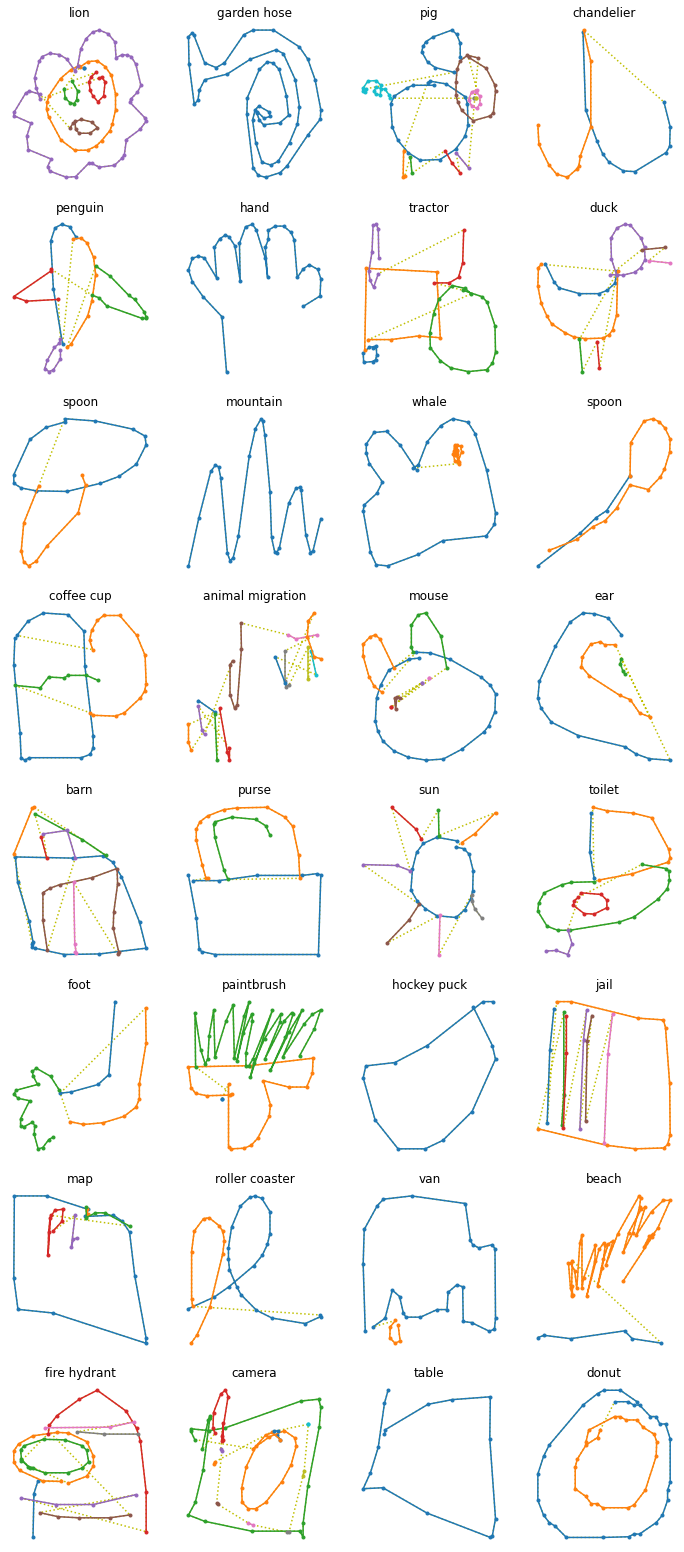

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = classes[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in tran_dataset.take(1):
    draw_sketches(sketches, lengths, labels)

In [ ]:
def mprep(dataset):
    return dataset.map(lambda inks, lengths, labels: (inks, labels))

train_set = mprep(tran_dataset)
valid_set = mprep(valid_dataset)
test_set = mprep(test_dataset)

##### Модель 1

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Layer(input_shape=[None, 3]),
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(len(classes), activation="softmax")
])

In [ ]:
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
107813/107813 [==============================] - 1062s 10ms/step - loss: 4.4494 - accuracy: 0.1176 - sparse_top_k_categorical_accuracy: 0.2890 - val_loss: 3.5845 - val_accuracy: 0.2231 - val_sparse_top_k_categorical_accuracy: 0.4844
Epoch 2/5
107813/107813 [==============================] - 1011s 9ms/step - loss: 2.9255 - accuracy: 0.3403 - sparse_top_k_categorical_accuracy: 0.6256 - val_loss: 2.6641 - val_accuracy: 0.3836 - val_sparse_top_k_categorical_accuracy: 0.6753
Epoch 3/5
107813/107813 [==============================] - 1012s 9ms/step - loss: 2.3894 - accuracy: 0.4398 - sparse_top_k_categorical_accuracy: 0.7270 - val_loss: 2.3161 - val_accuracy: 0.4506 - val_sparse_top_k_categorical_accuracy: 0.7398
Epoch 4/5
107813/107813 [==============================] - 1028s 10ms/step - loss: 2.1463 - accuracy: 0.4883 - sparse_top_k_categorical_accuracy: 0.7685 - val_loss: 2.1110 - val_accuracy: 0.4949 - val_sparse_top_k_categorical_accuracy: 0.7751
Epoch 5/5
107813/107813 [=====

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/model91")
#model = keras.models.load_model("/content/sample_data/model91")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model91/assets


##### Тестирование модели 1

In [ ]:
y_test = np.concatenate([labels for _, labels in test_set])
y_pred = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred))

0.79918045

In [ ]:
test_items = np.concatenate([item for item, _ in test_set.take(1)])[:3]
y_pred = model.predict(test_items)

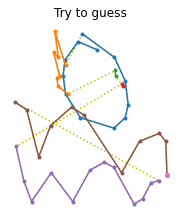

Probabilities:
speedboat with 38.99%
crab with 14.72%
mouse with 6.35%
frog with 4.30%
bird with 4.26%



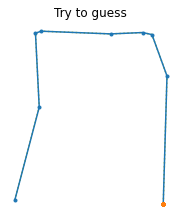

Probabilities:
skyscraper with 61.71%
finger with 10.14%
bench with 8.57%
nail with 6.66%
matches with 2.25%



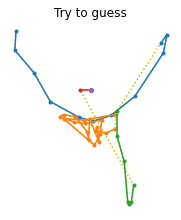

Probabilities:
arm with 38.20%
goatee with 29.55%
elbow with 13.31%
necklace with 6.00%
stethoscope with 3.13%



In [ ]:
for i in range(3):
  plt.figure(figsize=(3, 3.5))
  draw_sketch(test_items[i])
  plt.show()
  descr = tf.nn.top_k(y_pred[i], k=5)
  print("Probabilities:")
  for c in range(5):
    prob = descr.values[c].numpy()*100
    s = classes[descr.indices[c]]
    print("{} with {:3.2f}%".format(s, prob))
  print()

##### Модель 2

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 3]))
for rate in (1,2,4,8)*2:
  model.add(keras.layers.Conv1D(filters=5, kernel_size=2, padding="causal", 
                                activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=len(classes), kernel_size=1))

In [ ]:
def model2_prep(dataset, tpoints=96):
  d = dataset.map(lambda x,y: (x, tf.reshape(y, shape=(-1,1))))
  d = d.map(lambda x,y: (x, tf.repeat(y, tf.shape(x)[1], axis=1)))
  return d

In [ ]:
train_set2 = model2_prep(train_set)
valid_set2 = model2_prep(valid_set)
test_set2  = model2_prep(test_set)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

model = keras.models.Sequential([
  keras.layers.Layer(input_shape=[None, 3]),
  keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                      activation="relu", dilation_rate=1),
  keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                      activation="relu", dilation_rate=2),
  keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                      activation="relu", dilation_rate=4),
  keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                      activation="relu", dilation_rate=8),
  keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                      activation="relu", dilation_rate=16),

  keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
  keras.layers.BatchNormalization(),
  keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
  keras.layers.BatchNormalization(),
  keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
  keras.layers.BatchNormalization(),

  keras.layers.GRU(128, return_sequences=True),
  keras.layers.GRU(128),
  keras.layers.Dense(len(classes), activation="softmax")
])

In [ ]:
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
#optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
107813/107813 [==============================] - 1315s 12ms/step - loss: 4.3163 - accuracy: 0.1350 - sparse_top_k_categorical_accuracy: 0.3196 - val_loss: 3.6939 - val_accuracy: 0.2095 - val_sparse_top_k_categorical_accuracy: 0.4613
Epoch 2/5
107813/107813 [==============================] - 1328s 12ms/step - loss: 2.9085 - accuracy: 0.3444 - sparse_top_k_categorical_accuracy: 0.6283 - val_loss: 2.8146 - val_accuracy: 0.3545 - val_sparse_top_k_categorical_accuracy: 0.6453
Epoch 3/5
107813/107813 [==============================] - 1274s 12ms/step - loss: 2.4256 - accuracy: 0.4337 - sparse_top_k_categorical_accuracy: 0.7196 - val_loss: 2.3405 - val_accuracy: 0.4497 - val_sparse_top_k_categorical_accuracy: 0.7358
Epoch 4/5
107813/107813 [==============================] - 1296s 12ms/step - loss: 2.1860 - accuracy: 0.4811 - sparse_top_k_categorical_accuracy: 0.7609 - val_loss: 2.1947 - val_accuracy: 0.4777 - val_sparse_top_k_categorical_accuracy: 0.7592
Epoch 5/5
107813/107813 [===

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/model92")
#model = keras.models.load_model("/content/sample_data/model92")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model92/assets


##### Тестирование модели 2

In [ ]:
y_test = np.concatenate([labels for _, labels in test_set])
y_pred = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred))

0.78643465

In [ ]:
test_items = np.concatenate([item for item, _ in test_set.take(1)])[:3]
y_pred = model.predict(test_items)

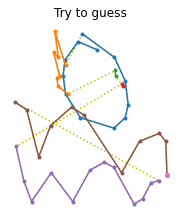

Probabilities:
speedboat with 31.46%
mouth with 7.78%
ocean with 4.42%
mouse with 3.65%
bat with 3.50%



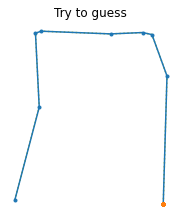

Probabilities:
skyscraper with 41.22%
bench with 17.12%
door with 15.01%
diving board with 5.53%
square with 3.08%



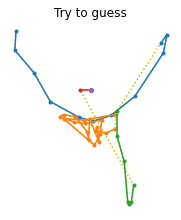

Probabilities:
goatee with 25.10%
necklace with 15.98%
elbow with 15.41%
arm with 10.34%
stethoscope with 4.44%



In [ ]:
for i in range(3):
  plt.figure(figsize=(3, 3.5))
  draw_sketch(test_items[i])
  plt.show()
  descr = tf.nn.top_k(y_pred[i], k=5)
  print("Probabilities:")
  for c in range(5):
    prob = descr.values[c].numpy()*100
    s = classes[descr.indices[c]]
    print("{} with {:3.2f}%".format(s, prob))
  print()

In [ ]:
arr = [2, 5, 7, 1]
arr2 = np.array(arr).reshape(2,2)

In [ ]:
tf.ragged.constant(arr2, ragged_rank=1)

<tf.RaggedTensor [[2, 5], [7, 1]]>